In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifake-vgg16-extracted-features/REAL_Test_Features.csv
/kaggle/input/cifake-vgg16-extracted-features/FAKE_Train_Features.csv
/kaggle/input/cifake-vgg16-extracted-features/FAKE_Test_Features.csv
/kaggle/input/cifake-vgg16-extracted-features/REAL_Train_Features.csv
/kaggle/input/demo-vgg16-extracted/Fake_Demo_Features.csv
/kaggle/input/demo-vgg16-extracted/Real_Demo_Features.csv


In [2]:
!nvidia-smi

Mon May 15 04:43:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install scikeras

In [4]:
!pip install "dask[complete]"
!pip install "dask-ml[complete]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.1/961.1 kB 31.4 MB/s eta 0:00:00
  Attempting uninstall: distributed
    Found existing installation: distributed 2023.3.2.1
    Uninstalling distributed-2023.3.2.1:
      Successfully uninstalled distributed-2023.3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
raft-dask 23.4.0 requires dask==2023.3.2, but you have dask 2023.4.0 which is incompatible.
raft-dask 23.4.0 requires distributed==2023.3.2.1, but you have distributed 2023.4.0 which is incompatible.
dask-cudf 23.4.0 requires dask==2023.3.2, but you have dask 2023.4.0 which is incompatible.
dask-cudf 23.4.0 requires distributed==2023.3.2.1, but you have distributed 2023.4.0 which is incompatible.


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.preprocessing import LabelEncoder
from time import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
def train_data_vgg16(sample_size=1.0):
    df_real = pd.read_csv("/kaggle/input/cifake-vgg16-extracted-features/REAL_Train_Features.csv")
    df_fake = pd.read_csv("/kaggle/input/cifake-vgg16-extracted-features/FAKE_Train_Features.csv")
    df = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)
    
    df_sample = df.sample(frac=sample_size, random_state=0)
    
    X = df_sample.drop('class', axis=1)
    
    le = LabelEncoder()
    y = df_sample['class']
    y = pd.DataFrame(le.fit_transform(y), columns=['class'])  # encode y to be numeric
    
    return (X, y)

def test_data_vgg16():
    df_real = pd.read_csv("/kaggle/input/cifake-vgg16-extracted-features/REAL_Test_Features.csv")
    df_fake = pd.read_csv("/kaggle/input/cifake-vgg16-extracted-features/FAKE_Test_Features.csv")
    
    df = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)
    X = df.drop('class', axis=1)
    
    le = LabelEncoder()
    y = df['class']
    y = pd.DataFrame(le.fit_transform(y), columns=['class'])  # encode y to be numeric
    
    return (X, y)

In [7]:
X, y = train_data_vgg16(sample_size=1.0)

In [8]:
param_grid = {
    'learning_rate': [0.005,0.001,0.01, 0.1, 0.5],
    'max_depth':  np.arange(1,5 ,1),
    'n_estimators': np.arange(1500, 3100, 100)
}

In [9]:
def create_xgb_model(learning_rate, max_depth, n_estimators):
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        tree_method='gpu_hist'
    )
    return model

In [10]:
#model = KerasRegressor(build_fn=create_xgb_model, verbose=0)
model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    return_train_score=True
)
gbtCV = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)


In [11]:
with tf.device('/GPU:0'):
    time_start = time()
    gbtCV.fit(X, y)
    time_stop = time()
    
    print(f"Time elapsed: {(time_stop - time_start) / 60.0:.2f} minutes")

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

Time elapsed: 237.23 minutes


In [12]:
gbtCV.best_score_

0.8993900063798143

In [13]:
gbtCV.best_params_

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 2900}

In [14]:
ix = gbtCV.cv_results_['mean_test_score'].argmax()
#gbtCV.cv_results_['mean_train_score'][ix].round(4)
gbtCV.cv_results_['mean_test_score'][ix].round(4)


0.8994

In [15]:
X, y = test_data_vgg16()

In [16]:
gbtCV.score(X,y)

0.90425

In [17]:
def demo_data_vgg16():
    df_real = pd.read_csv("/kaggle/input/demo-vgg16-extracted/Real_Demo_Features.csv")
    df_fake = pd.read_csv("/kaggle/input/demo-vgg16-extracted/Fake_Demo_Features.csv")
    
    df = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)
    X = df.drop('class', axis=1)
    
    le = LabelEncoder()
    y = df['class']
    y = pd.DataFrame(le.fit_transform(y), columns=['class'])  # encode y to be numeric
    
    return (X, y)

In [18]:
X,y = demo_data_vgg16()

In [19]:
gbtCV.score(X,y)

0.6904761904761905

<AxesSubplot: xlabel='param_max_depth-param_learning_rate', ylabel='param_n_estimators'>

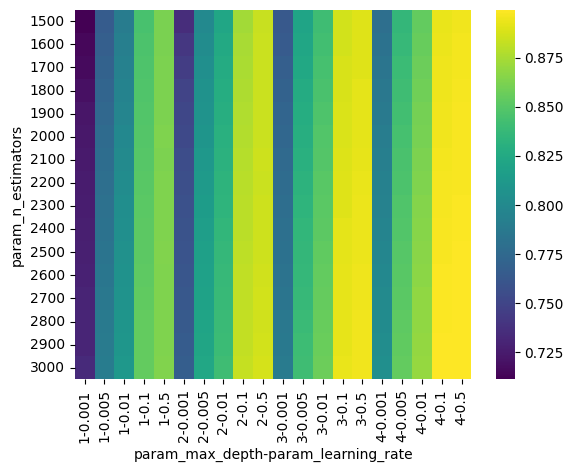

In [20]:
import seaborn as sns

cv_results = gbtCV.cv_results_
df_results = pd.DataFrame(cv_results)
df_results = df_results[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score']]
df_results = df_results.pivot_table(index='param_n_estimators', columns=['param_max_depth', 'param_learning_rate'], values='mean_test_score')
sns.heatmap(df_results, cmap='viridis')

In [21]:
model = xgb.XGBClassifier(learning_rate= 0.5, max_depth= 4, n_estimators= 1920,tree_method='gpu_hist',
    return_train_score=True
)

In [22]:
X,y = train_data_vgg16(sample_size=1.0)
model.fit(X,y)
model.score(X,y)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1.0

In [23]:
df_real = pd.read_csv("/kaggle/input/cifake-vgg16-extracted-features/REAL_Test_Features.csv")
df_fake = pd.read_csv("/kaggle/input/cifake-vgg16-extracted-features/Fake_Test_Features.csv")
df_test = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)

 

y_test = df_test['class']

SyntaxError: invalid non-printable character U+00A0 (70856688.py, line 5)

In [ ]:
[9:26 pm] Bowering, Ryan




prediction = svmTest.predict(X_test)

 

le = LabelEncoder()

le.fit(y_test)

prediction = le.inverse_transform(prediction)

prediction

In [ ]:
confusion = pd.DataFrame()
confusion['target'] = y_test
confusion['prediction'] = prediction
confusion.head()

In [ ]:
# True Positive = Real Real
# False Positive = Fake Real
# True Negative = Fake Fake
# False Negative = Real Fake
confusion.value_counts()